In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42

import seaborn as sns

sns.set_theme(style="dark")
import sys



from scripts.paper_figures.data_processing.data_processing import main as init_data
from scripts.paper_figures.data_processing.process_pumping import ProboscisProcessing


In [2]:
# Initialize Data
llh, process_data, io_process,expt_info_df = init_data()

Data Loading and Preprocessing...
Saving Experiment Info...
Data already exists. No data was saved.
Loading Likelihood data...
Loading existing llh_df.pickle file...


In [3]:
def transform_data(process_data):
    # Transforms the data into dictionary of dataframe format.
    df_dict = {}
    for name, group in process_data.data.groupby('ExptNames'):
        group = group.set_index('Idx')  # Set 'Idx' as the index
        df_dict[name] = group.drop('ExptNames', axis=1)  # Drop the 'ExptNames' column as it's redundant
    return df_dict

def convert_index_to_timedelta(df_dict,resample_rate = '30S'):
        # Loop through the dictionary and convert 'Idx' to 'Time' for each DataFrame
    for name, group_df in df_dict.items():
        group_df['Time'] = pd.to_timedelta(group_df.index / 30.0, unit='S')
        group_df.set_index('Time', inplace=True)
        
        # Now you can use resample on each DataFrame if needed. 
        # For example, to resample at 1-second intervals:
        df_dict[name] = group_df.resample(resample_rate).mean()
    return df_dict


In [49]:
fig_path = r'C:\Users\Grover\Documents\GitHub\deepsleepfigs'
import numpy as np
import os
import pandas as pd
def pad_data_for_keys(dict_of_df, resample_rate='30S'):
    # Calculate target length in rows for 6 hours of data
    # 6 hours = 6 * 60 minutes = 360 minutes = 360 * 60 seconds
    target_length_seconds = 6 * 60 * 60  
    resample_factor = pd.Timedelta(resample_rate).seconds
    target_length_resampled = target_length_seconds // resample_factor
    
    target_keys = ['Fly06242022_5d_SD_B', 'Fly06242022_5_SD_A']

    padded_dict_of_df = {}
    for key, df in dict_of_df.items():
        if key in target_keys:
            current_length = len(df)
            pad_length = target_length_resampled - current_length
            if pad_length > 0:
                # Create a DataFrame with zeros for padding
                pad_df = pd.DataFrame(
                    np.zeros((pad_length, df.shape[1])),
                    columns=df.columns,
                    index=pd.timedelta_range(
                        start=df.index[-1] + pd.Timedelta(seconds=resample_factor),
                        periods=pad_length,
                        freq=resample_rate
                    )
                )
                # Concatenate original DataFrame and pad DataFrame
                padded_df = pd.concat([df, pad_df])
            else:
                padded_df = df
        else:
            padded_df = df
        
        padded_dict_of_df[key] = padded_df
    
    return padded_dict_of_df


def normalize_data(data_array):
    """Normalize data array by its max value."""
    return data_array / np.max(data_array)

def plot_single_heatmap(ax, df_dict, column, xticks, ZT_ticklabels):
    heatmap_data = []
    
    for name, df in df_dict.items():
        data_array = df[column].values
        normalized_data = normalize_data(data_array)
        heatmap_data.append(normalized_data)

    average_data = np.mean(heatmap_data, axis=0)
    
    # Set xticks and tick labels
    ax[0].set_xticks(xticks)
    ax[0].set_xticklabels(ZT_ticklabels)
    ax[1].set_xticks(xticks)
    ax[1].set_xticklabels(ZT_ticklabels)

    # Create heatmaps and colorbars
    im = ax[0].imshow(heatmap_data, aspect='auto', cmap='magma', interpolation='none')
    im_avg = ax[1].imshow([average_data], aspect='auto', cmap='magma', interpolation='none')
    cbar = plt.colorbar(im, ax=ax[0], orientation='vertical', fraction=.1)
    cbar_avg = plt.colorbar(im_avg, ax=ax[1], orientation='vertical', fraction=.1)
    
    # Set titles and labels
    ax[0].set_title(f"{column} - Individual")
    ax[0].set_ylabel("Experiments")
    ax[1].set_title(f"{column} - Average")
    ax[1].set_ylabel("Average")
    cbar.set_label('Normalized Value')
    cbar_avg.set_label('Normalized Value')

def plot_stacked_heatmap(df_dict, columns, title, FPS=30, sd=False, resample_rate='1S'):
    # Convert resample_rate to seconds
    resample_factor = pd.Timedelta(resample_rate).seconds
    
    # Generate the ticks and labels
    xticks, ZT_ticklabels = generate_tick_data(FPS, sd, resample_factor)
    
    fig, axs = plt.subplots(len(columns), 2, figsize=(15, len(columns) * 5), sharex=True)
    
    if len(columns) == 1:
        axs = np.expand_dims(axs, axis=0)

    for idx, column in enumerate(columns):
        plot_single_heatmap(axs[idx], df_dict, column, xticks, ZT_ticklabels)

    plt.xlabel("Time (in frames)")
    plt.tight_layout()
    fig.savefig(os.path.join(fig_path, f'{title}_stacked_and_average_heatmap.pdf'))
    plt.show()

def generate_tick_data(FPS=30, sd=False, resample_factor=1):
    if sd == False:
        xticks = np.arange(
            start=0, stop=FPS * 60 * 60 * 16 + 1, step=FPS * 60 * 60 * 2
        ) // (resample_factor * FPS)
        ZT_ticks = xticks
        ZT_ticklabels = [
            "ZT" + str((tick + 10) % 24) for tick in range(0, len(xticks) * 2, 2)
        ]
    else:
        xticks = np.arange(
            start=0, stop=FPS * 60 * 60 * 6 + 1, step=FPS * 60 * 60 * 1
        ) // (resample_factor * FPS)
        ZT_ticks = xticks
        ZT_ticklabels = [
            "ZT" + str(tick) for tick in range(0, len(xticks) * 1, 1)
        ]

    return ZT_ticks, ZT_ticklabels

def filter_keys_by_conditions(name_to_sd, name_to_sex, sd, sex):
    valid_keys = []
    for name in name_to_sd.keys():
        if name_to_sd[name] == sd and name_to_sex[name] == sex:
            valid_keys.append(name)
    return valid_keys

name_to_sd = dict(zip(expt_info_df['ExptNames'], expt_info_df['SD']))
name_to_sex = dict(zip(expt_info_df['ExptNames'], expt_info_df['Sex']))


In [50]:
resample_rate = '120S'
dict_of_df = transform_data(process_data)
dict_of_df = convert_index_to_timedelta(dict_of_df,resample_rate)

names = pd.read_csv(r'C:\Users\Grover\Documents\GitHub\EZLabel\used_for_prob.csv')
filtered_dict_of_dfs = {key: df for key, df in dict_of_df.items() if key in names['0'].values}

# Using the function
padded_dict_of_dfs = pad_data_for_keys(filtered_dict_of_dfs, resample_rate)


In [57]:
sd = False
sex = 'M'
valid_keys = filter_keys_by_conditions(name_to_sd, name_to_sex, sd, sex)

[2023-10-16 16:27:10] INFO - maxp pruned
[2023-10-16 16:27:10] INFO - LTSH dropped
[2023-10-16 16:27:10] INFO - cmap pruned
[2023-10-16 16:27:10] INFO - kern dropped
[2023-10-16 16:27:10] INFO - post pruned
[2023-10-16 16:27:10] INFO - PCLT dropped
[2023-10-16 16:27:10] INFO - JSTF dropped
[2023-10-16 16:27:10] INFO - meta dropped
[2023-10-16 16:27:10] INFO - DSIG dropped
[2023-10-16 16:27:10] INFO - GPOS pruned
[2023-10-16 16:27:10] INFO - GSUB pruned
[2023-10-16 16:27:10] INFO - glyf pruned
[2023-10-16 16:27:10] INFO - Added gid0 to subset
[2023-10-16 16:27:10] INFO - Added first four glyphs to subset
[2023-10-16 16:27:10] INFO - Closing glyph list over 'GSUB': 47 glyphs before
[2023-10-16 16:27:10] INFO - Glyph names: ['.notdef', 'A', 'E', 'F', 'G', 'I', 'M', 'N', 'P', 'T', 'V', 'Z', 'a', 'ampersand', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'glyph00001', 'glyph00002', 'hyphen', 'i', 'j', 'l', 'm', 'minus', 'n', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'si

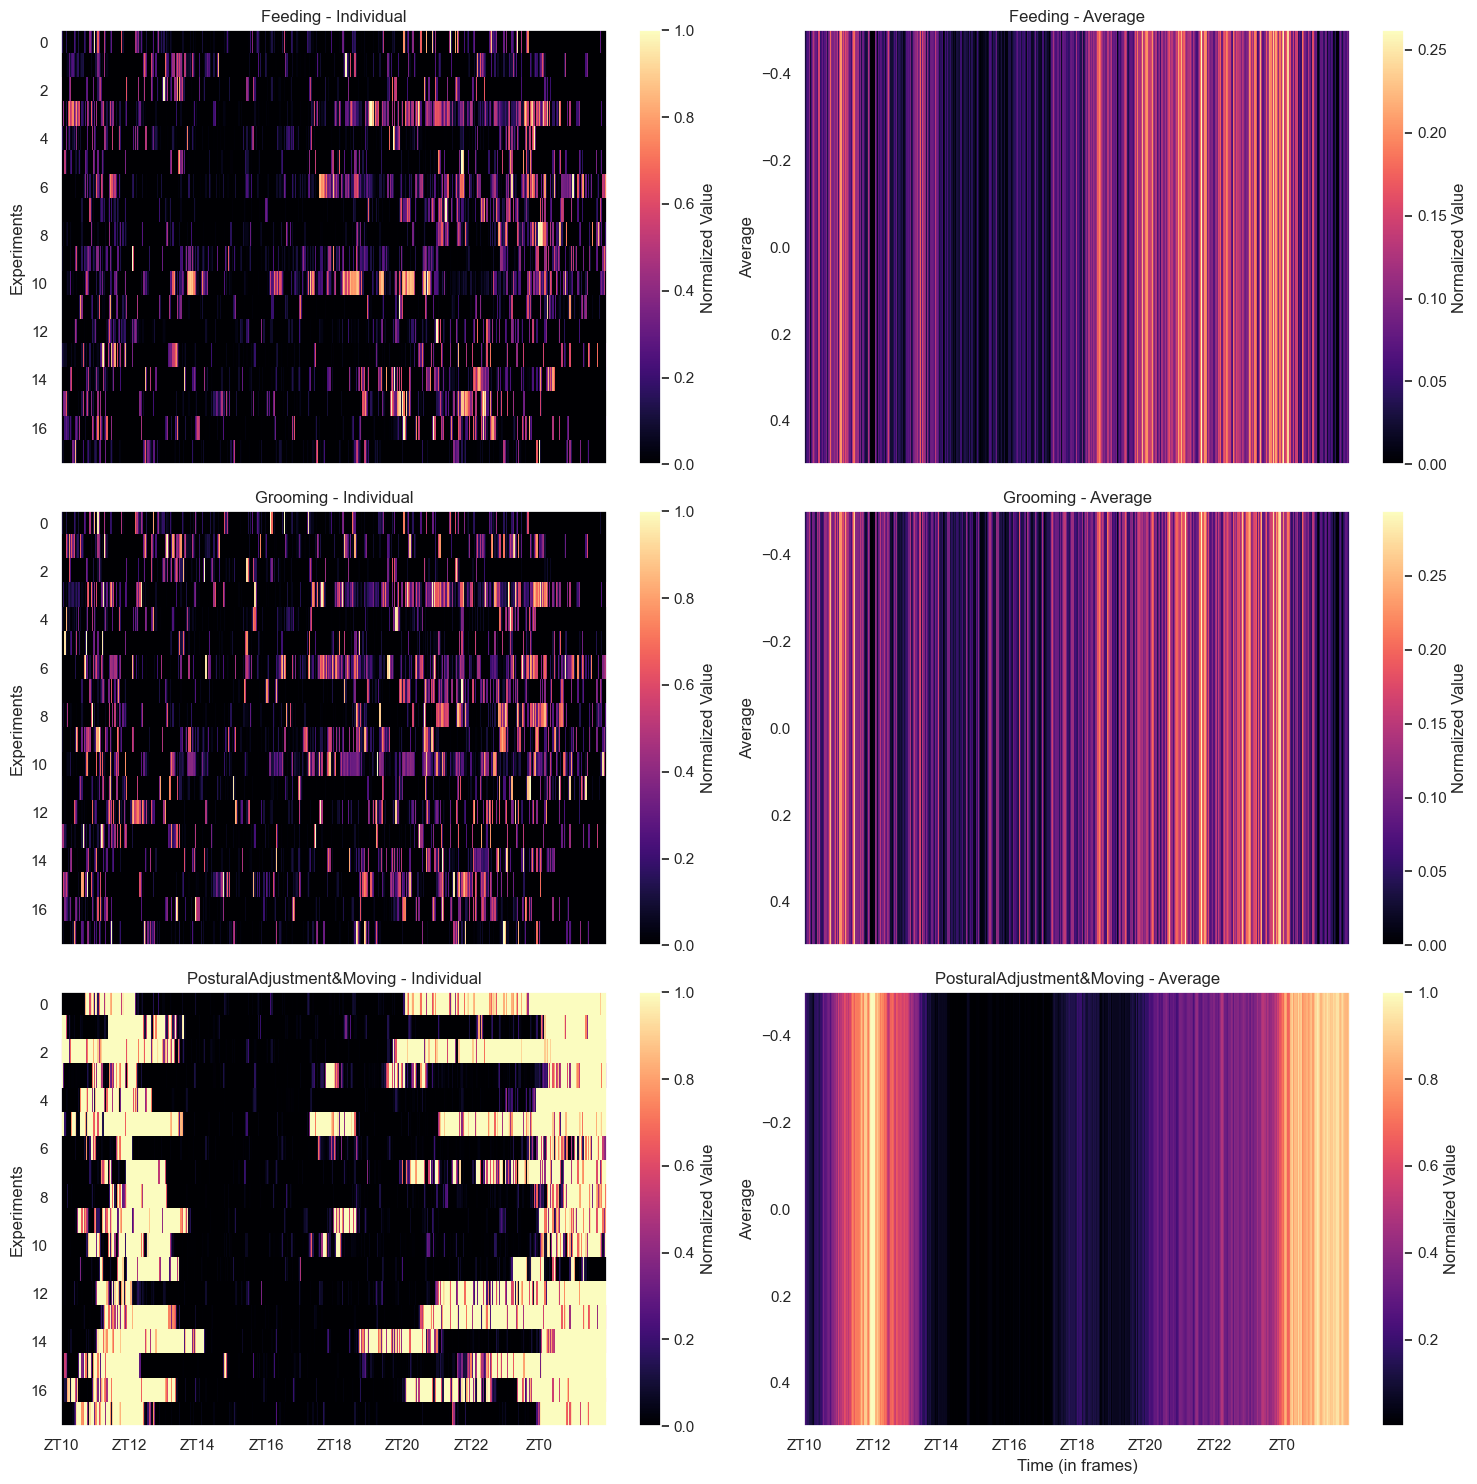

In [58]:
subset_dict_of_dfs = {key: df for key, df in padded_dict_of_dfs.items() if key in valid_keys}
title = f'SD_{sd}_Sex_{sex}_RS_{resample_rate}'
plot_stacked_heatmap(subset_dict_of_dfs,['Feeding','Grooming','PosturalAdjustment&Moving'],title,resample_rate=resample_rate,sd=sd)

In [ ]:
# Process proboscis bouts, change "load_bouts=True" if you want to load
proboscis = ProboscisProcessing(process_data, llh, io_process,force_recalculate=False)
proboscis.generate_prob_bouts(load_bouts=True)

In [ ]:
expt_info_df.ExptNames[1]

In [ ]:
from importlib import reload
import scripts.paper_figures.data_processing.process_macro_micro  # Import the module first

from importlib import reload

import basty.utils.misc
reload(basty.utils.misc)


# Now reload the module
reload(scripts.paper_figures.data_processing.process_macro_micro)

# Re-import your specific class/function
from scripts.paper_figures.data_processing.process_macro_micro import ExperimentOutline

expt_outline = ExperimentOutline(io_process.project.project_path)

bout_df_all, outline_df_all = expt_outline.outline_expt_all(expt_info_df)

merged_df = pd.merge(bout_df_all, expt_info_df, left_on='Experiment Name', right_on='ExptNames')

FIG_PATH = r"C:\Users\Grover\Documents\GitHub\deepsleepfigs"
save_micro_macro = os.path.join(FIG_PATH, "micro_macro_v2.pdf")

ExperimentOutline.plot_ethogram(merged_df,save_path=save_micro_macro)

In [ ]:
newDf = pd.merge(df_data, expt_info_df, left_on="ExptNames", right_on="ExptNames")

In [ ]:
wt_all = newDf[newDf["SD"] == False]
male_wt = wt_all[wt_all["Sex"] == "M"]
female_wt = wt_all[wt_all["Sex"] == "F"]

In [ ]:
filterer = FilterData(newDf, llh)

In [ ]:
filterer.plot_mean_likelihood()

In [ ]:
binary_mask = filterer.create_binary_masks(llh, BODY_PART_SETS, 0.7)

In [ ]:
masked_data_df = filterer.apply_binary_masks(binary_mask, newDf)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is called 'masked_data_df'
# and has columns 'ExptNames', 'ValueColumn' (replace with your actual column name)
# Add row numbers if they don't exist
masked_data_df["Row"] = masked_data_df.index

# Pivot the DataFrame
pivoted_df = masked_data_df.pivot(
    index="ExptNames", columns="Row", values="ProboscisPumping"
)

# Create a heatmap using Seaborn, handling NaN values with a different color (e.g., gray)
plt.figure(figsize=(16, 9))
sns.heatmap(
    pivoted_df,
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={"ticks": [0, 1]},
    mask=pivoted_df.isna(),
    linecolor="gray",
)

# Set plot attributes
plt.xlabel("Rows")
plt.ylabel("ExptNames")
plt.title("Heatmap of Data")

# Save the plot as a PNG file
FIG_PATH = r"C:\Users\Grover\Documents\GitHub\deepsleepfigs"
plt.savefig(f"{FIG_PATH}\\heatmap.png", dpi=300, bbox_inches="tight")

# Display the plot in the notebook (optional)
plt.show()

In [ ]:
plot_folder = r"C:\Users\Grover\Documents\GitHub\deepsleepfigs\score_plots"
if not os.path.isdir(plot_folder):
    os.makedirs(plot_folder)

In [ ]:
male_wt["Time"] = male_wt["Idx"].apply(BehaviorData.get_time_stamp)
male_wt.index = pd.to_datetime(list(male_wt["Time"]))
rate = "1S"
male_wt_rs = BehaviorData.resample_df(male_wt, rate, BEHAVIORS)
male_wt_rs["TimeStamp"] = male_wt_rs.index

In [ ]:
male_wt

In [ ]:
llh["Time"] = llh["Idx"].apply(BehaviorData.get_time_stamp)

In [ ]:
BehaviorData.pivot_and_plot(male_wt_rs, "mal_b_scr_", plot_folder, rate, BEHAVIORS)

In [ ]:
import os

In [ ]:
os.listdir(plot_folder)

In [ ]:
df_pivoted = male_wt_rs.pivot(
    index="ExptNames", columns="TimeStamp", values="ProboscisPumping"
)
a4_dims = (25.7, 5.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title("ProboscisPumping")
ax = sns.heatmap(df_pivoted, cmap="YlGnBu")

In [ ]:
male_wt_rs

In [ ]:
unique_expt_names = male_wt["ExptNames"].unique()

a4_dims = (25.7, 5.27)
# Plot the unmasked data heatmap
# plt.figure(figsize=(a4_dims))
# sns.heatmap(unmasked_data, cmap='YlGnBu', yticklabels=unique_expt_names)
# plt.xlabel('Data')
# plt.ylabel('ExptNames')
# plt.title('Unmasked Data')
# plt.savefig(os.path.join(plot_folder,'unmasked_data_heatmap_full_07.png'), dpi=300)  # Save the figure as a PNG file
# plt.show()

In [ ]:
# Plot the masked data heatmap
plt.figure(figsize=(a4_dims))
sns.heatmap(masked_data, cmap="YlGnBu", yticklabels=unique_expt_names)
plt.xlabel("Data")
plt.ylabel("ExptNames")
plt.title("Masked Data")
plt.savefig(os.path.join(plot_folder, "masked_data_heatmap_full_09.png"), dpi=300)
plt.show()

In [ ]:
snap_paths = [
    {expt_names: os.path.join(project.project_path, expt_names, "snap_stft.pkl")}
    for expt_names in project.expt_names
]
snap_col_names = [
    os.path.join(project.project_path, expt_names, "ftname_to_snapft.yaml")
    for expt_names in project.expt_names
]

In [ ]:
df_data

In [ ]:
df_data